In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import numpy as np
import matplotlib.pyplot as plt

In [4]:
(train_images, _), (_, _) = datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [5]:
clothing_types = ["Футболка", "Штани", "Светр", "Сукня", "Пальто", "Сандалі", "Сорочка", "Кросівки", "Сумка", "Чоботи"]
print("Типи одягу у датасеті Fashion MNIST:")
for i, clothing_type in enumerate(clothing_types):
    print(f"{i+1}: {clothing_type}")

Типи одягу у датасеті Fashion MNIST:
1: Футболка
2: Штани
3: Светр
4: Сукня
5: Пальто
6: Сандалі
7: Сорочка
8: Кросівки
9: Сумка
10: Чоботи


In [6]:
batch_size = 2048
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(batch_size)

In [7]:
def make_generator_model():
    model = models.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [8]:
def make_discriminator_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
epochs = 5
noise_dim = 100
num_examples_to_generate = 16

In [12]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for i, image_batch in enumerate(dataset):
            print(f"\rBatch {i+1}/{len(train_images)//batch_size}", end="")
            train_step(image_batch)
        print()

In [14]:
train(train_dataset, epochs)

Epoch 1/5
Batch 30/29
Epoch 2/5
Batch 30/29
Epoch 3/5
Batch 30/29
Epoch 4/5
Batch 30/29
Epoch 5/5
Batch 30/29


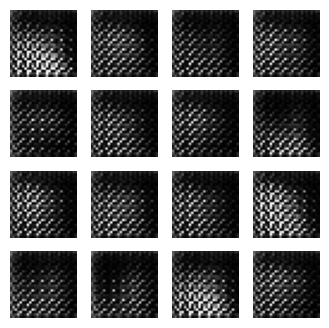

In [15]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

generate_and_save_images(generator, epochs, seed)

In [ ]:
#Думаю, проблема в тому, що я встановиив замало епох, однак ці 5, з якоїсь причини, тривали 2 години. Я спробую встановити 20 та дочекатися, і, якщо стане краще - надішлю завдання знову. Вибачте.